### Import packages

In [4]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from pydub import AudioSegment
import os

2025-08-19 11:15:23.819993: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-19 11:15:23.882752: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-19 11:15:23.953609: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755602124.016638    2655 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755602124.035145    2655 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755602124.152170    2655 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### Ingest data

In [1]:
def convert_and_resample(input_file: str, output_file: str):
    """
    Converts an audio file to WAV format and resamples it to 16 kHz.
    Skips conversion if the output file already exists.

    Args:
        input_file (str): Path to the input audio file (e.g., .ogg, .mp3).
        output_file (str): Path to save the converted and resampled .wav file.
    """
    if os.path.exists(output_file):
        print(f"Skipped (already exists): {output_file}")
        return

    try:
        # Load the input audio file
        audio = AudioSegment.from_file(input_file)
        # Resample to 16 kHz
        audio_16k = audio.set_frame_rate(16000)
        # Export as .wav
        audio_16k.export(output_file, format="wav")
        print(f"Conversion and resampling successful: {output_file}")
    except Exception as e:
        print(f"Error during conversion and resampling: {e}")

In [2]:
def batch_convert_and_resample(input_root, output_root, convert_and_resample, max_folders=None):
    """
    Walk through input_root, find all .ogg files, and convert them to .wav
    in output_root with the same folder structure.
    
    Parameters:
        input_root (str): Path to the root folder containing .ogg files.
        output_root (str): Path where converted .wav files will be saved.
        convert_and_resample (func): Function that takes (in_path, out_path).
        max_folders (int, optional): If set, only process the first N subfolders.
    """
    # List top-level subfolders in input_root
    subfolders = sorted(
        [os.path.join(input_root, d) for d in os.listdir(input_root) 
         if os.path.isdir(os.path.join(input_root, d))]
    )

    # Limit to first N folders if requested
    if max_folders is not None:
        subfolders = subfolders[:max_folders]

    for folder in subfolders:
        for dirpath, _, filenames in os.walk(folder):
            for filename in filenames:
                if filename.lower().endswith(".ogg"):
                    in_path = os.path.join(dirpath, filename)
                    
                    # Build matching output path
                    rel_path = os.path.relpath(in_path, input_root)
                    rel_path_no_ext = os.path.splitext(rel_path)[0] + ".wav"
                    out_path = os.path.join(output_root, rel_path_no_ext)

                    # Ensure output directory exists
                    os.makedirs(os.path.dirname(out_path), exist_ok=True)

                    # Convert
                    convert_and_resample(in_path, out_path)
                    print(f"Converted: {in_path} -> {out_path}")

In [3]:
input_root = "../data/birdclef-2024/train_audio"
output_root = "../data/wav"

batch_convert_and_resample(input_root, output_root, convert_and_resample)


NameError: name 'os' is not defined

In [ ]:
# Read train meta data
train_metadata_path = "../data/birdclef-2024/train_metadata.csv"
train_df = pd.read_csv(train_metadata_path)


### EDA

In [ ]:
train_df.head()

In [ ]:
# train_df["rating"].info()
train_df.describe()

### Read wav bird data

In [41]:
# Read train meta data
base_data_path = "../data/birdclef-2024"
bird_metadata_path = os.path.join(base_data_path, "train_metadata.csv")
bird_df = pd.read_csv(bird_metadata_path)

# Display the first few rows of the dataframe
bird_df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg


In [42]:

# Change the filename endings from .ogg to .wav in the filename column of bird_df
bird_df['filename'] = bird_df['filename'].str.replace('.ogg', '.wav', regex=False)
# Display the first few rows of the dataframe
bird_df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.wav
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.wav
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.wav
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.wav
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.wav


In [43]:
import glob
# # Show rows where the filename matches the pattern "cohcuc1/*.wav"
# bird_df[bird_df['filename'].str.startswith('cohcuc1/') & bird_df['filename'].str.endswith('.wav')].head()
wav_files = glob.glob(base_data_path + "/train_audio/**/*.wav", recursive=True)
wav_files = [f.replace(base_data_path + "/train_audio/", "") for f in wav_files]

filtered_bird_df = bird_df[bird_df['filename'].isin(wav_files)]

bird_classes = list(set(filtered_bird_df['common_name']))

map_class_to_id = {name: idx for idx, name in enumerate(bird_classes)}

# filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_bird_df['common_name'].apply(lambda name: map_class_to_id[name])
filtered_bird_df = filtered_bird_df.assign(target=class_id)


full_path = filtered_bird_df['filename'].apply(lambda row: os.path.join(base_data_path + "/train_audio/", row))
filtered_bird_df = filtered_bird_df.assign(filename=full_path)

filtered_bird_df.head(10)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,target
4676,cohcuc1,[],"['call', 'song']",13.347000,74.789000,Hierococcyx varius,Common Hawk-Cuckoo,Ramit Singal,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/136837,../data/birdclef-2024/train_audio/cohcuc1/XC13...,0
4677,cohcuc1,[],['call'],17.675100,75.326800,Hierococcyx varius,Common Hawk-Cuckoo,Sushant more,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/140254,../data/birdclef-2024/train_audio/cohcuc1/XC14...,0
4678,cohcuc1,[],"['call', 'song']",30.267700,78.035900,Hierococcyx varius,Common Hawk-Cuckoo,Ashutosh Singh,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/174932,../data/birdclef-2024/train_audio/cohcuc1/XC17...,0
4679,cohcuc1,[],['song'],6.389700,80.501400,Hierococcyx varius,Common Hawk-Cuckoo,Senehas Karunarathna,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/177780,../data/birdclef-2024/train_audio/cohcuc1/XC17...,0
4680,cohcuc1,"['grecou1', 'pursun3']",['song'],11.275900,76.218800,Hierococcyx varius,Common Hawk-Cuckoo,Vivek Puliyeri,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/191169,../data/birdclef-2024/train_audio/cohcuc1/XC19...,0
4681,cohcuc1,[],['song'],26.658965,86.990004,Hierococcyx varius,Common Hawk-Cuckoo,David Farrow,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/19645,../data/birdclef-2024/train_audio/cohcuc1/XC19...,0
4682,cohcuc1,[],['call'],15.434600,74.098500,Hierococcyx varius,Common Hawk-Cuckoo,Pankaj Lad,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/214005,../data/birdclef-2024/train_audio/cohcuc1/XC21...,0
4683,cohcuc1,[],['call'],15.434600,74.098500,Hierococcyx varius,Common Hawk-Cuckoo,Pankaj Lad,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/214006,../data/birdclef-2024/train_audio/cohcuc1/XC21...,0
15477,integr,[],['call'],13.854900,100.473500,Ardea intermedia,Intermediate Egret,Werzik,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/397702,../data/birdclef-2024/train_audio/integr/XC397...,1
15478,integr,[],"['call', 'flight call']",13.942800,100.422000,Ardea intermedia,Intermediate Egret,Werzik,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://www.xeno-canto.org/401712,../data/birdclef-2024/train_audio/integr/XC401...,1


### Split data into trainig, validation and test data

In [61]:
from sklearn.model_selection import train_test_split

train_df_idx, temp_df_idx = train_test_split(filtered_bird_df.index, test_size=0.3, random_state=42, stratify=filtered_bird_df['target'])

val_df_idx, test_df_idx = train_test_split(temp_df_idx, test_size=0.5, random_state=42, stratify=filtered_bird_df.loc[temp_df_idx, 'target'])

# Step 3: Create 'fold' column in original filtered_bird_df
filtered_bird_df['fold'] = ''  # initialize empty
filtered_bird_df.loc[train_df_idx, 'fold'] = 1
filtered_bird_df.loc[val_df_idx, 'fold'] = 2
filtered_bird_df.loc[test_df_idx, 'fold'] = 3

filtered_bird_df.head(100)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,target,fold
4676,cohcuc1,[],"['call', 'song']",13.347000,74.789000,Hierococcyx varius,Common Hawk-Cuckoo,Ramit Singal,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/136837,../data/birdclef-2024/train_audio/cohcuc1/XC13...,0,1
4677,cohcuc1,[],['call'],17.675100,75.326800,Hierococcyx varius,Common Hawk-Cuckoo,Sushant more,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/140254,../data/birdclef-2024/train_audio/cohcuc1/XC14...,0,1
4678,cohcuc1,[],"['call', 'song']",30.267700,78.035900,Hierococcyx varius,Common Hawk-Cuckoo,Ashutosh Singh,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/174932,../data/birdclef-2024/train_audio/cohcuc1/XC17...,0,1
4679,cohcuc1,[],['song'],6.389700,80.501400,Hierococcyx varius,Common Hawk-Cuckoo,Senehas Karunarathna,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/177780,../data/birdclef-2024/train_audio/cohcuc1/XC17...,0,1
4680,cohcuc1,"['grecou1', 'pursun3']",['song'],11.275900,76.218800,Hierococcyx varius,Common Hawk-Cuckoo,Vivek Puliyeri,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/191169,../data/birdclef-2024/train_audio/cohcuc1/XC19...,0,3
4681,cohcuc1,[],['song'],26.658965,86.990004,Hierococcyx varius,Common Hawk-Cuckoo,David Farrow,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/19645,../data/birdclef-2024/train_audio/cohcuc1/XC19...,0,1
4682,cohcuc1,[],['call'],15.434600,74.098500,Hierococcyx varius,Common Hawk-Cuckoo,Pankaj Lad,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/214005,../data/birdclef-2024/train_audio/cohcuc1/XC21...,0,2
4683,cohcuc1,[],['call'],15.434600,74.098500,Hierococcyx varius,Common Hawk-Cuckoo,Pankaj Lad,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/214006,../data/birdclef-2024/train_audio/cohcuc1/XC21...,0,1
15477,integr,[],['call'],13.854900,100.473500,Ardea intermedia,Intermediate Egret,Werzik,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/397702,../data/birdclef-2024/train_audio/integr/XC397...,1,1
15478,integr,[],"['call', 'flight call']",13.942800,100.422000,Ardea intermedia,Intermediate Egret,Werzik,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://www.xeno-canto.org/401712,../data/birdclef-2024/train_audio/integr/XC401...,1,1


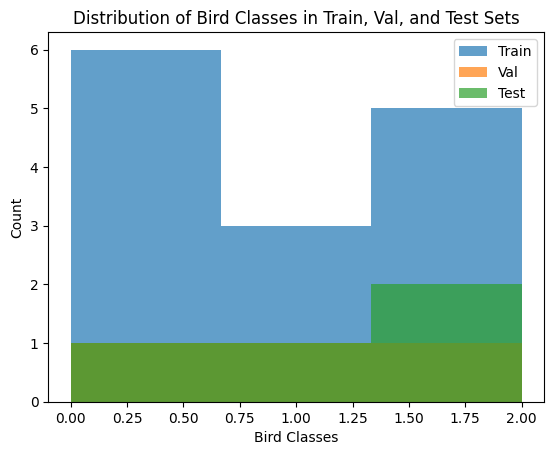

In [62]:
plt.hist(filtered_bird_df[filtered_bird_df['fold'] == 1]['target'], bins=len(bird_classes), alpha=0.7, label='Train')
plt.hist(filtered_bird_df[filtered_bird_df['fold'] == 2]['target'], bins=len(bird_classes), alpha=0.7, label='Val')
plt.hist(filtered_bird_df[filtered_bird_df['fold'] == 3]['target'], bins=len(bird_classes), alpha=0.7, label='Test')
plt.xlabel('Bird Classes')
plt.ylabel('Count')
plt.title('Distribution of Bird Classes in Train, Val, and Test Sets')
plt.legend()
plt.show()

### Modelling

In [ ]:
# Load the model.
model = hub.load('https://tfhub.dev/google/yamnet/1')

#### Model inference / Create Embeddings

#### Model classification layer

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1024,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  # z. B. 10 Klassen
])